# Project: Image Classification and Regression

## LALANNE Clément

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Getting Started: Import the code given

In [2]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

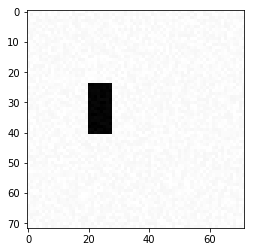

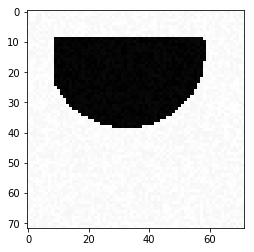

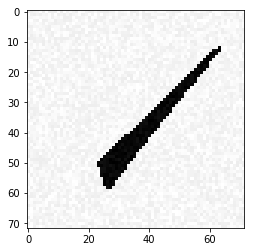

In [3]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

im = generate_a_disk(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

[im, v] = generate_a_triangle(20, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    for i in range(nb_samples):
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# Simple Linear Classification

I tried the SGD optimizer but the ADAM one works much better here so I will stick to this one.

In [4]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Input, UpSampling2D, Cropping2D, concatenate, ZeroPadding2D, Dropout
from keras.optimizers import SGD
from keras.utils import to_categorical

Using TensorFlow backend.


First I will implement a simple linear classifier. I use a softmax activation function in order to have a probability distribution implementation.

In [5]:
nb_cat = 3
linear_model = Sequential([
            Dense(nb_cat, input_shape=(IMAGE_SIZE*IMAGE_SIZE,)),
            Activation('softmax')])

For the optimization I use the ADAM optimizer along with a cross entropy loss function.

In [6]:
sgd = SGD(lr=0.01,
decay=1e-6, momentum=0.9,
nesterov=True)
linear_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [7]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

In [8]:
linear_model.fit(X_train, to_categorical(Y_train, num_classes=nb_cat, dtype='float32'), epochs=10, batch_size=32)

Epoch 1/10
300/300 [==============================] - 1s 2ms/step - loss: 1.5548
Epoch 2/10
300/300 [==============================] - 0s 83us/step - loss: 0.7902
Epoch 3/10
300/300 [==============================] - 0s 94us/step - loss: 0.4722
Epoch 4/10
300/300 [==============================] - 0s 97us/step - loss: 0.3652
Epoch 5/10
300/300 [==============================] - 0s 100us/step - loss: 0.3022
Epoch 6/10
300/300 [==============================] - 0s 113us/step - loss: 0.2619
Epoch 7/10
300/300 [==============================] - 0s 87us/step - loss: 0.2353
Epoch 8/10
300/300 [==============================] - 0s 102us/step - loss: 0.2024
Epoch 9/10
300/300 [==============================] - 0s 84us/step - loss: 0.1784
Epoch 10/10
300/300 [==============================] - 0s 87us/step - loss: 0.1884


In [9]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0])
linear_model.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

In [10]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
linear_model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [11]:
[X_test, tmp] = generate_a_triangle()
X_test = X_test.reshape(1, X_test.shape[0])
linear_model.predict(X_test)

array([[0., 0., 1.]], dtype=float32)

The labels are right.

## Visualization of the solution

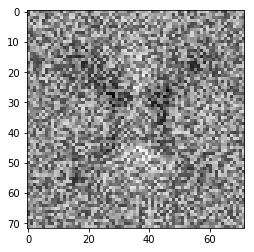

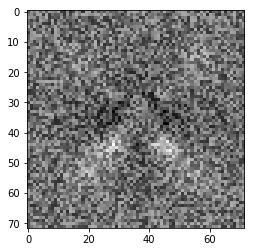

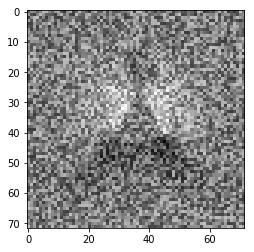

In [12]:
weights = linear_model.get_weights()[0]
for i in range(nb_cat):
    plt.imshow(weights[:, i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.show()

## A more difficult classification problem

In [13]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

For this network I will use 2 convolutional layers with 16 and 32 features maps and filters of size 5x5 with relu activation functions and Maxpooling on 2x2 frames.

In [14]:
nb_neurons = 20
cnn_model = Sequential()
cnn_model.add(Conv2D(16, (5, 5), activation='relu',input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(32, (5, 5), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(nb_neurons))
cnn_model.add(Activation('relu'))
cnn_model.add(Dense(nb_cat))
cnn_model.add(Activation('softmax'))

In [15]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
X_train_reshaped = X_train.reshape((X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
cnn_model.fit(X_train_reshaped, to_categorical(Y_train, num_classes=nb_cat, dtype='float32'), batch_size=32, epochs=30, verbose=1)

Epoch 1/30
300/300 [==============================] - 1s 3ms/step - loss: 1.0993 - acc: 0.3533
Epoch 2/30
300/300 [==============================] - 0s 265us/step - loss: 1.0397 - acc: 0.5200
Epoch 3/30
300/300 [==============================] - 0s 251us/step - loss: 0.9380 - acc: 0.5200
Epoch 4/30
300/300 [==============================] - 0s 255us/step - loss: 0.8347 - acc: 0.5900
Epoch 5/30
300/300 [==============================] - 0s 244us/step - loss: 0.7451 - acc: 0.7133
Epoch 6/30
300/300 [==============================] - 0s 248us/step - loss: 0.6832 - acc: 0.6967
Epoch 7/30
300/300 [==============================] - 0s 244us/step - loss: 0.5907 - acc: 0.7600
Epoch 8/30
300/300 [==============================] - 0s 229us/step - loss: 0.5436 - acc: 0.7667
Epoch 9/30
300/300 [==============================] - 0s 232us/step - loss: 0.4835 - acc: 0.8500
Epoch 10/30
300/300 [==============================] - 0s 220us/step - loss: 0.3994 - acc: 0.8667
Epoch 11/30
300/300 [==========

In [47]:
[X_test, Y_test] = generate_test_set_classification()

In [48]:
X_test_reshaped = X_test.reshape((X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
cnn_model.evaluate(X_test_reshaped, to_categorical(Y_test, num_classes=nb_cat, dtype='float32'))

300/300 [==============================] - 0s 116us/step


[0.5735190622011821, 0.8333333333333334]

On the last return we ran read the value of the loss function on the test set on the left and the accuracy on the right.

## A regression problem

I had troubles having relevant results here. I found that I had better results by sorting the vertices.

In [5]:
def ordonancer(Y):
    for i in range(Y.shape[0]):
        cop = np.copy(Y[i, :])
        args = np.argsort(cop[0::2])
        for j in range(3):
            Y[i, 2*j] = cop[2*args[j]]
            Y[i, 2*j+1] = cop[2*args[j]+1]
    return Y

In [19]:
[X_train, Y_train] = generate_dataset_regression(10000, 20)
Y_train = ordonancer(Y_train)

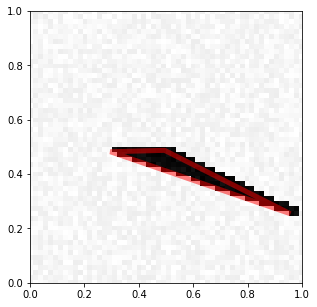

In [20]:
k = np.random.randint(X_train.shape[0])
visualize_prediction(X_train[k], Y_train[k])

In [21]:
#renormalization
#norm_train = np.sum(Y_train, axis=1)[:, np.newaxis]
#Y_train = np.concatenate((Y_train/norm_train,norm_train), axis=1) 

I used a CNN with 4 conv layers and a fully connected network with 3 hidden layers.

In [22]:
inputs = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1))

conv1 = Conv2D(64, (5, 5), activation='relu', padding='same')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, (5, 5), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, (5, 5), activation='relu', padding='same')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, (5, 5), activation='relu', padding='same')(pool3)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv_feat = Flatten()(pool3)

fc1 = Dense(100, activation='relu')(conv_feat)
fc2 = Dense(50, activation='relu')(fc1)
fc3 = Dense(15, activation='relu')(fc2)

outputs = Dense(6, activation='sigmoid')(fc2)

regression_cnn_model = Model(inputs=inputs, outputs=outputs)

In [23]:
regression_cnn_model.compile(loss='mean_absolute_error', optimizer='adam')
X_train_reshaped = X_train.reshape((X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
regression_cnn_model.fit(X_train_reshaped, Y_train, batch_size=32, epochs=200, verbose=1)

Epoch 1/200
10000/10000 [==============================] - 10s 1ms/step - loss: 0.0869
Epoch 2/200
10000/10000 [==============================] - 9s 932us/step - loss: 0.0387
Epoch 3/200
10000/10000 [==============================] - 10s 995us/step - loss: 0.0304
Epoch 4/200
10000/10000 [==============================] - 9s 940us/step - loss: 0.0267
Epoch 5/200
10000/10000 [==============================] - 9s 933us/step - loss: 0.0245
Epoch 6/200
10000/10000 [==============================] - 10s 962us/step - loss: 0.0229
Epoch 7/200
10000/10000 [==============================] - 10s 985us/step - loss: 0.0214
Epoch 8/200
10000/10000 [==============================] - 10s 952us/step - loss: 0.0200
Epoch 9/200
10000/10000 [==============================] - 9s 932us/step - loss: 0.0195
Epoch 10/200
10000/10000 [==============================] - 9s 931us/step - loss: 0.0180
Epoch 11/200
10000/10000 [==============================] - 9s 929us/step - loss: 0.0172
Epoch 12/200
10000/10000 [=

10000/10000 [==============================] - 9s 933us/step - loss: 0.0067
Epoch 94/200
10000/10000 [==============================] - 9s 933us/step - loss: 0.0065
Epoch 95/200
10000/10000 [==============================] - 9s 931us/step - loss: 0.0065
Epoch 96/200
10000/10000 [==============================] - 9s 934us/step - loss: 0.0066
Epoch 97/200
10000/10000 [==============================] - 9s 932us/step - loss: 0.0066
Epoch 98/200
10000/10000 [==============================] - 9s 933us/step - loss: 0.0065
Epoch 99/200
10000/10000 [==============================] - 9s 930us/step - loss: 0.0065
Epoch 100/200
10000/10000 [==============================] - 9s 932us/step - loss: 0.0064
Epoch 101/200
10000/10000 [==============================] - 9s 932us/step - loss: 0.0065
Epoch 102/200
10000/10000 [==============================] - 9s 928us/step - loss: 0.0065
Epoch 103/200
10000/10000 [==============================] - 9s 929us/step - loss: 0.0065
Epoch 104/200
10000/10000 [===

10000/10000 [==============================] - 9s 935us/step - loss: 0.0053
Epoch 185/200
10000/10000 [==============================] - 9s 936us/step - loss: 0.0053
Epoch 186/200
10000/10000 [==============================] - 9s 934us/step - loss: 0.0053
Epoch 187/200
10000/10000 [==============================] - 9s 932us/step - loss: 0.0052
Epoch 188/200
10000/10000 [==============================] - 9s 932us/step - loss: 0.0053
Epoch 189/200
10000/10000 [==============================] - 9s 933us/step - loss: 0.0052
Epoch 190/200
10000/10000 [==============================] - 9s 932us/step - loss: 0.0054
Epoch 191/200
10000/10000 [==============================] - 9s 933us/step - loss: 0.0052
Epoch 192/200
10000/10000 [==============================] - 9s 932us/step - loss: 0.0061
Epoch 193/200
10000/10000 [==============================] - 9s 934us/step - loss: 0.0063
Epoch 194/200
10000/10000 [==============================] - 9s 933us/step - loss: 0.0059
Epoch 195/200
10000/1000

In [24]:
[X_test, Y_test] = generate_test_set_regression()
Y_test = ordonancer(Y_test)
#renormalization
#norm_test = np.sum(Y_test, axis=1)[:, np.newaxis]
#Y_test = np.concatenate((Y_test/norm_test,norm_test), axis=1) 

In [25]:
X_test_reshaped = X_test.reshape((X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
Y_test_pred = regression_cnn_model.predict(X_test_reshaped)

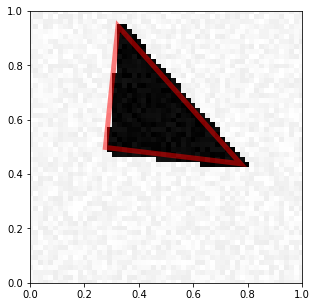

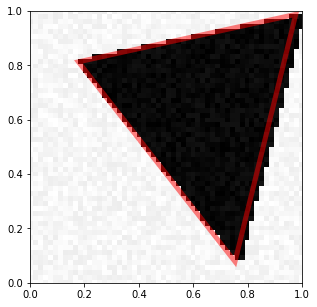

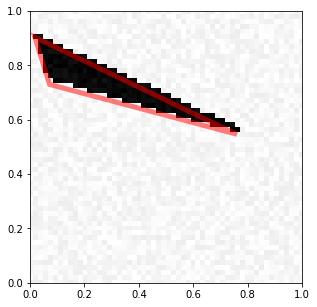

In [29]:
Y_test_pred = Y_test_pred 
for i in range(3):
    k = np.random.randint(X_test.shape[0])
    visualize_prediction(X_test[k], Y_test_pred[k])

I can't say if the results are even decent. I thought that I can use u R-RNN to put boxes on the vertices but it seems not to be the spirit of the question. However I'm sure it would give better results.

## Image Denoising

In [27]:
def generate_a_rectangle_denoising(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0.)


def generate_a_disk_denoising(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0.)

def generate_a_triangle_denoising(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return generate_a_drawing(figsize, U, V, noise), generate_a_drawing(figsize, U, V, 0.)

def generate_dataset_denoising(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    for i in range(nb_samples):
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle_denoising(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk_denoising(noise, free_location)
        else:
            X[i], Y[i] = generate_a_triangle_denoising(noise, free_location)
    X = (X + noise) / (255 + 2 * noise)
    Y = (Y + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_denoising():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, 20, True)
    return [X_test, Y_test]

In [28]:
def get_crop_shape(f1, f2):
    s1 = f1.get_shape().as_list()
    s2 = f2.get_shape().as_list()
    t1 = (s1[1] - s2[1])//2
    t2 = s1[1] - s2[1] - t1
    t3 = (s1[2] - s2[2])//2
    t4 = s1[2] - s2[2] - t3
    return (( t1, t2), (t3 , t4))

I made a hourglass network with two downsampling/upsampling steps.

In [29]:
concat_axis = 3 

inputs = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1))

conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)

up_conv3 = UpSampling2D(size=(2, 2))(conv3)
ch, cw = get_crop_shape(conv2, up_conv3)
crop_conv2 = Cropping2D(cropping=(ch,cw))(conv2)
up4 = concatenate([up_conv3, crop_conv2], axis=concat_axis)
conv4 = Conv2D(16, (3, 3), activation='relu', padding='same')(up4)

up_conv2 = UpSampling2D(size=(2, 2))(conv2)
ch, cw = get_crop_shape(conv1, up_conv2)
crop_conv1 = Cropping2D(cropping=(ch,cw))(conv1)
up5 = concatenate([up_conv2, crop_conv1], axis=concat_axis)
conv5 = Conv2D(8, (3, 3), activation='relu', padding='same')(up5)

ch, cw = get_crop_shape(inputs, conv5)
conv6 = ZeroPadding2D(padding=((ch[0], ch[1]), (cw[0], cw[1])))(conv5)
up6 = concatenate([conv6, inputs], axis=concat_axis)
conv7 = Conv2D(8, (3, 3), activation='relu', padding='same')(up6)

outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv7)

denoising_model = Model(inputs=inputs, outputs=outputs)

In [30]:
[X_train, Y_train] = generate_dataset_denoising(300, 20)

In [31]:
denoising_model.compile(loss='mean_squared_error', optimizer='adam')
X_train_reshaped = X_train.reshape((X_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
Y_train_reshaped = X_train.reshape((Y_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
denoising_model.fit(X_train_reshaped, Y_train_reshaped, batch_size=32, epochs=15, verbose=1)

Epoch 1/15
300/300 [==============================] - 1s 4ms/step - loss: 0.1678
Epoch 2/15
300/300 [==============================] - 0s 496us/step - loss: 0.1282
Epoch 3/15
300/300 [==============================] - 0s 457us/step - loss: 0.0874
Epoch 4/15
300/300 [==============================] - 0s 471us/step - loss: 0.0519
Epoch 5/15
300/300 [==============================] - 0s 460us/step - loss: 0.0187
Epoch 6/15
300/300 [==============================] - 0s 500us/step - loss: 0.0055
Epoch 7/15
300/300 [==============================] - 0s 475us/step - loss: 0.0039
Epoch 8/15
300/300 [==============================] - 0s 449us/step - loss: 0.0036
Epoch 9/15
300/300 [==============================] - 0s 456us/step - loss: 0.0033
Epoch 10/15
300/300 [==============================] - 0s 447us/step - loss: 0.0030
Epoch 11/15
300/300 [==============================] - 0s 472us/step - loss: 0.0027
Epoch 12/15
300/300 [==============================] - 0s 471us/step - loss: 0.0025
Epo

In [32]:
[X_test, Y_test] = generate_test_set_denoising()

In [33]:
X_test_reshaped = X_test.reshape((X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))
Y_test_pred_reshaped = denoising_model.predict(X_test_reshaped)

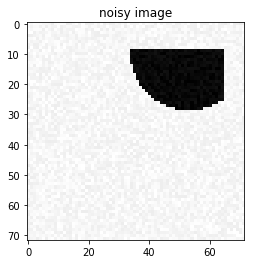

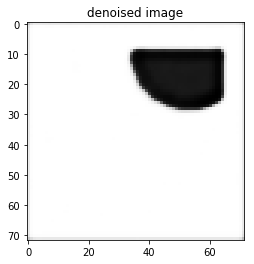

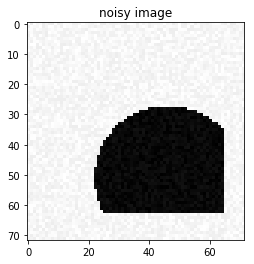

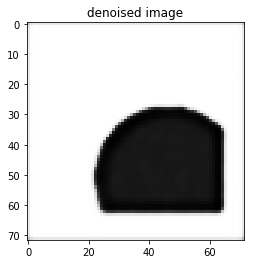

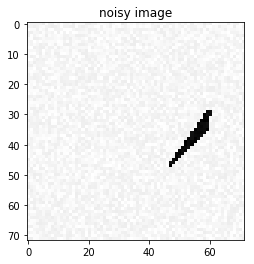

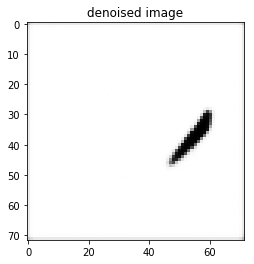

In [34]:
for i in range(3):
    k = np.random.randint(X_test.shape[0])
    plt.imshow(X_test_reshaped[k, :, :, 0],  cmap='gray')
    plt.title("noisy image")
    plt.show()
    plt.imshow(Y_test_pred_reshaped[k, :, :, 0], cmap='gray')
    plt.title("denoised image")
    plt.show()

The results here are really good.